In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable


class LinearControlSystem:

    def __init__(
        self,
        input_parameters: dict,
        u: Callable,
        z: Callable,
        time: float

    ):
        self.u = u
        self.z = z
        self.time = time
        m1, d1, k1, m2, d2, k2 = input_parameters.values()
        self.A = np.array([
            [0, -(k2 + k1) / m1, 0, k2 / m1],
            [1, -(d2 + d1) / m1, 0, d2 / m1],
            [0, k2 / m2, 0, -k2 / m2],
            [0, d2 / m2, 1, -d2 / m2]
        ])
        self.B = np.array([k1 / m1, d1 / m1, 0, 0]).reshape(-1, 1)
        self.d1 = d1
        self.y1_height_baseline = 0.3
        self.y2_height_baseline = 0.6

    def compute_eigenvalues(self):
        eigenvalues, eigenvectors = np.linalg.eig(self.A)
        return print("Eigenvalues:", eigenvalues)

    def compute_max_elevation(self):
        # Compute maximum elevation difference y2(t) - y1(t)
        elevation_diff = self.x_values[:, 3] - self.x_values[:, 1]

        max_elevation = np.max(elevation_diff)
        max_time = self.time_steps[np.argmax(elevation_diff)]

        print(f"Maximum Elevation Difference (y2 - y1): {max_elevation:.4f} m")
        print(f"Time of Maximum Elevation: t = {max_time:.4f} s")

        return max_elevation, max_time

    def compute_speeds(self):
        C = np.array([
            [0, 1, 0, 0],  # y1'(t)
            [0, 0, 0, 1]   # y2'(t)
        ])
        speeds = []
        for x, u_val in zip(self.x_values, self.u_values):
            x = x.reshape(-1, 1)
            y_dot = C @ (self.A @ x + self.B * u_val)
            speeds.append(y_dot.flatten())
        speeds = np.array(speeds)
        return speeds

    def solve(self, initial_conditions: dict, step_size: float = 0.1):
        self.x_values = []
        self.u_values = []
        x = np.array(list(initial_conditions.values())).reshape(-1, 1)
        self.time_steps =  np.linspace(0, self.time, int(self.time / step_size))

        for t in self.time_steps:
            self.x_values.append(x.flatten())
            self.u_values.append(self.u(self.z(t)))
            dx = self.A @ x + self.B * self.u(self.z(t))
            x = x + dx * step_size

    def get_y1(self):
        df = pd.DataFrame({
        'y1': np.array(self.x_values)[:, 1],
        'time_steps': self.time_steps,
        'd1': self.d1
        })
        return df


    def plot(self, plot_u=False, deviation_only=False):
        self.x_values = np.array(self.x_values)
        plt.figure(figsize=(10, 6))

        if deviation_only==True:
            y1_height_baseline = 0
            y2_height_baseline = 0
        else:
            y1_height_baseline = self.y1_height_baseline
            y2_height_baseline = self.y2_height_baseline
        
        plt.plot(self.time_steps, self.x_values[:, 1] + y1_height_baseline, label="Body - y1 (Velocity of mass 1)")
        plt.plot(self.time_steps, self.x_values[:, 3] + y2_height_baseline, label="Chair - y2 (Velocity of mass 2)")

        if plot_u==True: 
            plt.plot(self.time_steps, self.u_values, label="u(t)")

        plt.xlabel("Time (s)")
        plt.ylabel("State Variables")
        plt.title("State Variables of the Linear Control System (Euler Method)")
        plt.legend()
        plt.grid(True)

        plt.show()


# Assignment 3

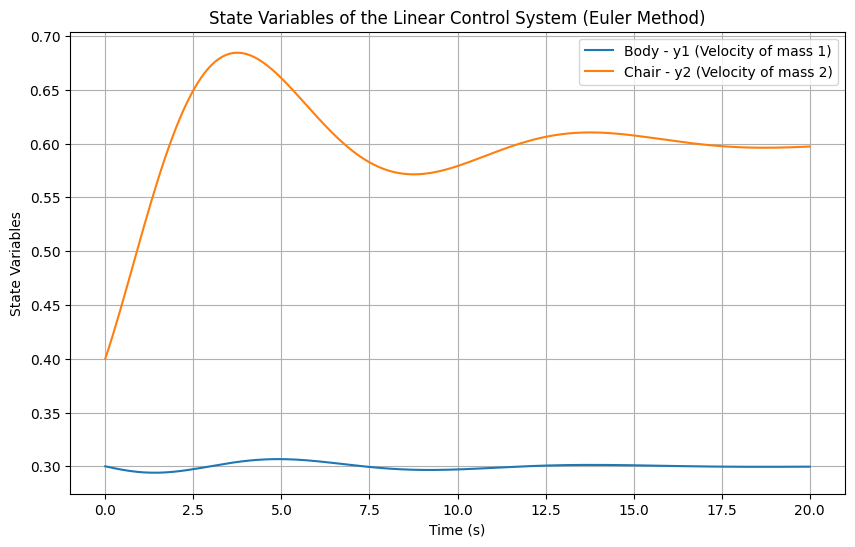

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [26]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 50, "k2": 50}


initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": -0.2} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()


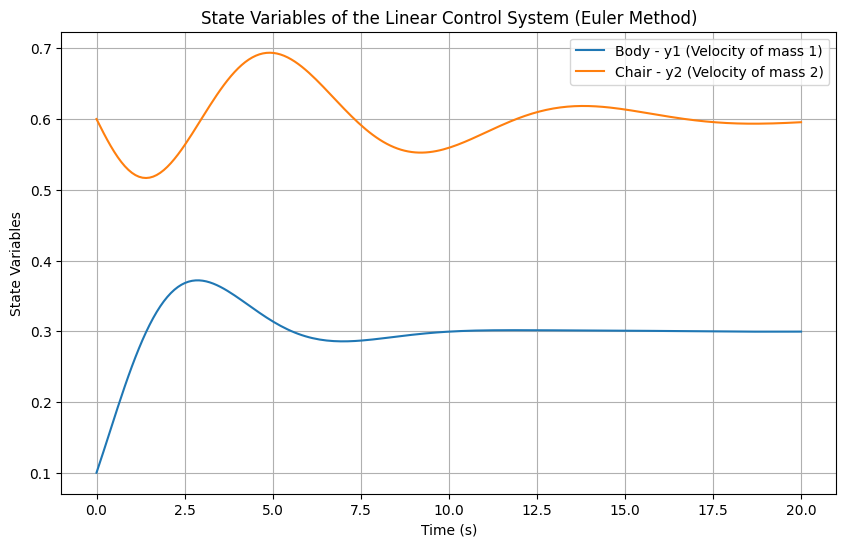

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [27]:
u = lambda t: 0
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 4

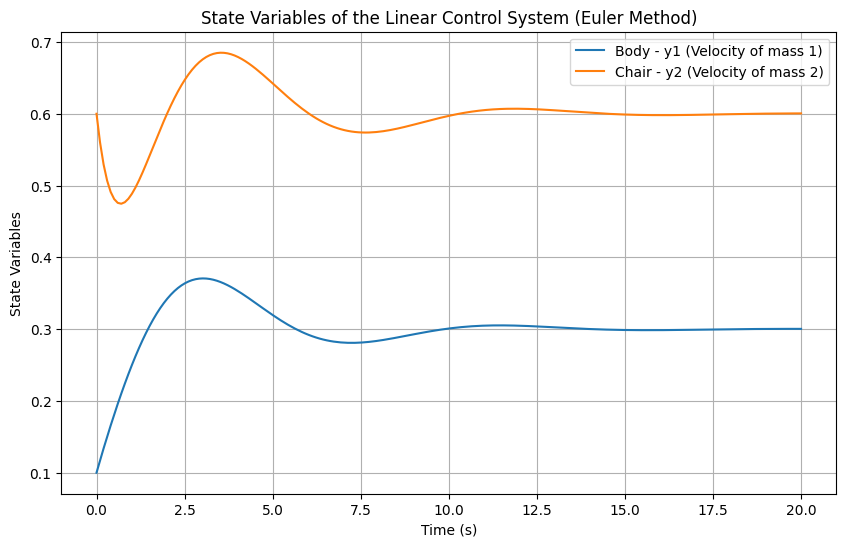

Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [28]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 5

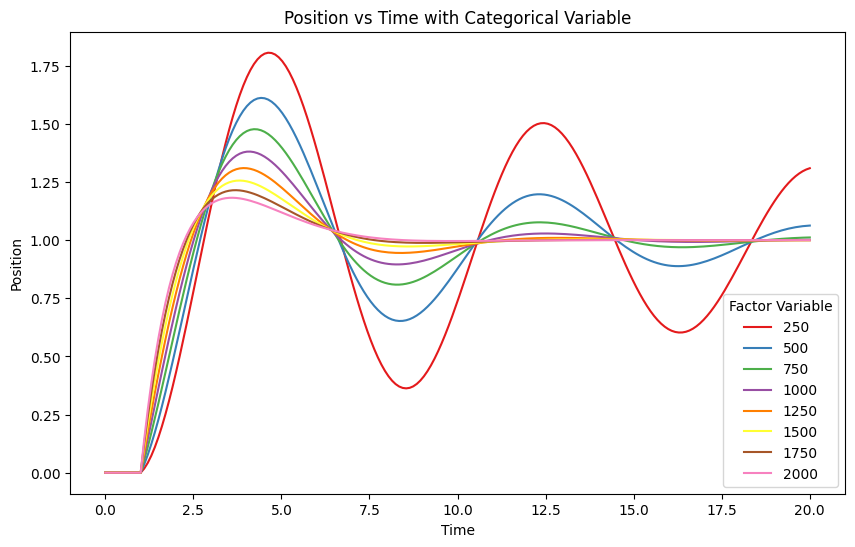

In [29]:
u = lambda t: 0 if t<1 else 1
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

df_list = []

for d1 in np.arange(250,2000+1,250):

    input_parameters = {"m1":1400, "d1": d1, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
    model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
    model.solve(initial_conditions)
    df = model.get_y1()
    df_list.append(df)

df = pd.concat(df_list)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='time_steps', y='y1', hue='d1', palette='Set1')

plt.title('Position vs Time with Categorical Variable')
plt.xlabel('Time')
plt.ylabel('Position')

plt.legend(title='Factor Variable')
plt.show()

# Assignment 6

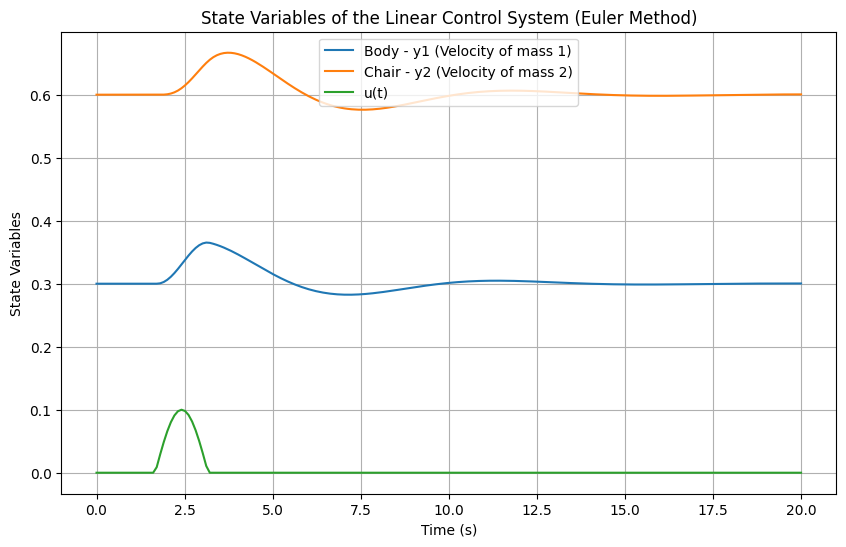

Maximum Elevation Difference (y2 - y1): 0.0211 m
Time of Maximum Elevation: t = 4.5226 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [30]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 7

Bump s=1.5

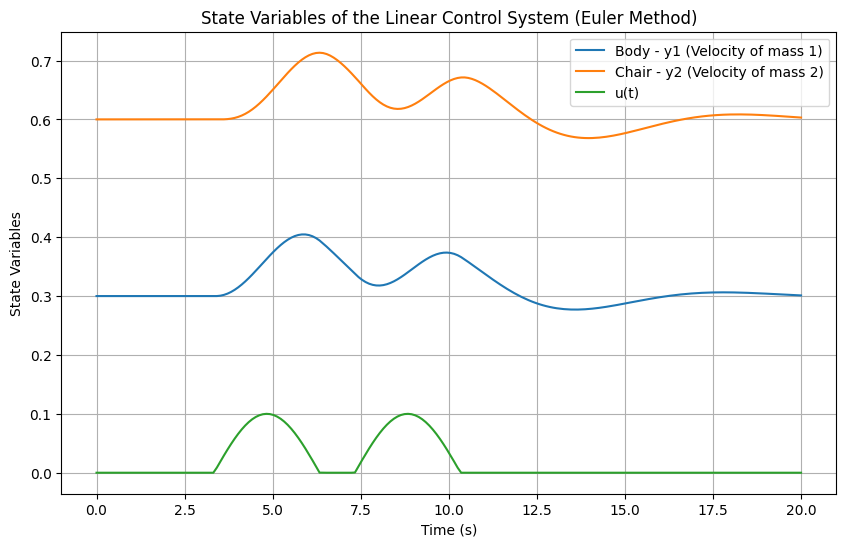

Maximum Elevation Difference (y2 - y1): 0.0352 m
Time of Maximum Elevation: t = 7.1357 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [31]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 1.5*t

u_s1_5 = lambda z: 0.1 * np.cos(-0.6981*(z-7.25-(4.5+1.5))) if 11 <= z <= 15.5 else 0
u_sum1_5 = lambda z: u(z)+u_s1_5(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum1_5, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Bump s=0

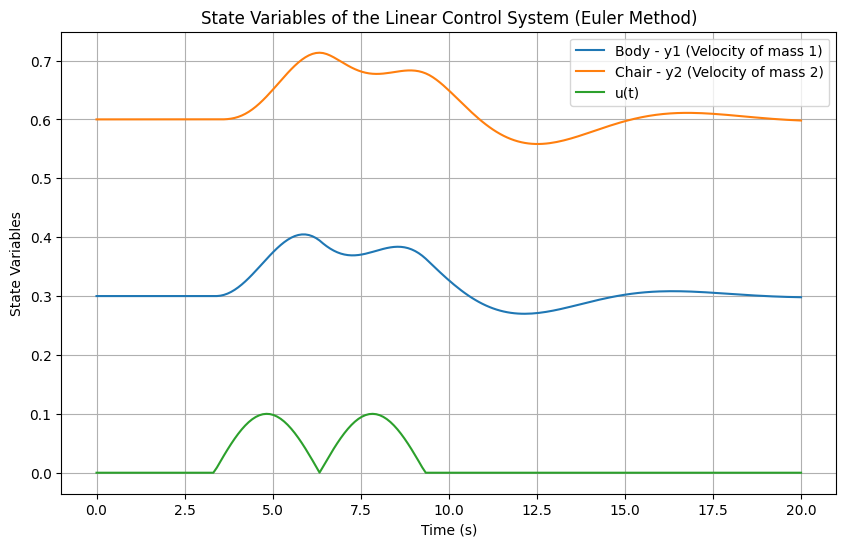

Maximum Elevation Difference (y2 - y1): 0.0282 m
Time of Maximum Elevation: t = 6.7337 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [32]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 1.5*t

u_s0 = lambda z: 0.1 * np.cos(-0.6981*(z-7.25-(4.5))) if 9.5 <= z <= 14 else 0
u_sum0 = lambda z: u(z)+u_s0(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum0, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 8

Speed = 3m/s

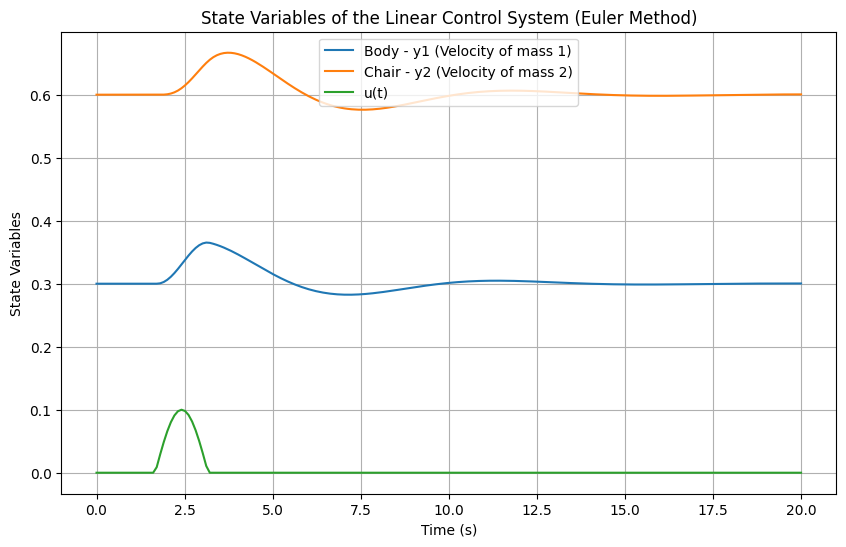

Maximum Elevation Difference (y2 - y1): 0.0211 m
Time of Maximum Elevation: t = 4.5226 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [33]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Speed = 10 m/s

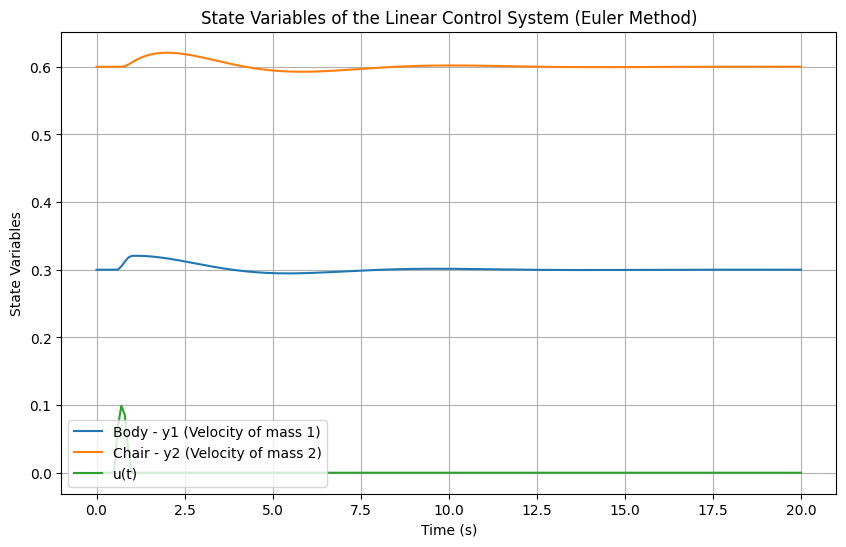

Maximum Elevation Difference (y2 - y1): 0.0066 m
Time of Maximum Elevation: t = 2.7136 s
Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [34]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 10*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 9

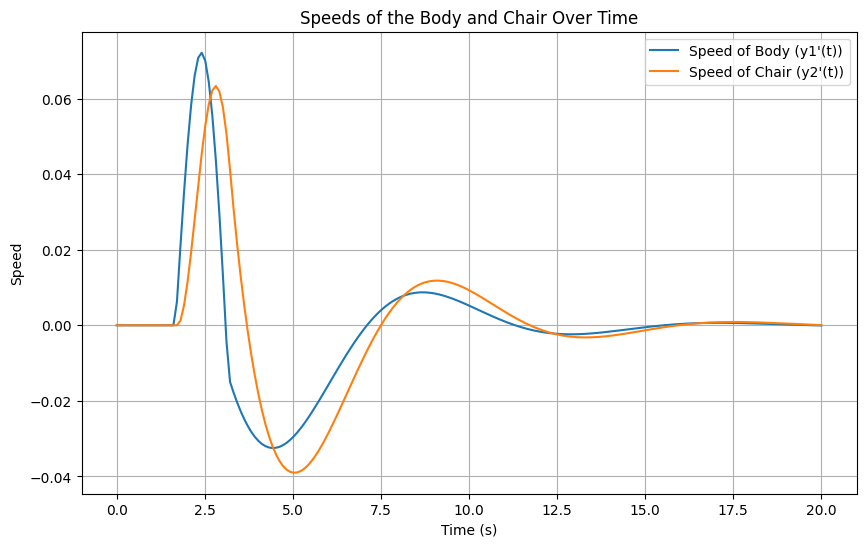

Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [35]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0}


model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)

speeds = model.compute_speeds()

plt.figure(figsize=(10, 6))
plt.plot(model.time_steps, speeds[:, 0], label="Speed of Body (y1'(t))")
plt.plot(model.time_steps, speeds[:, 1], label="Speed of Chair (y2'(t))")
plt.xlabel("Time (s)")
plt.ylabel("Speed")
plt.title("Speeds of the Body and Chair Over Time")
plt.legend()
plt.grid()
plt.show()
model.compute_eigenvalues()